In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 21.6 MB/s eta 0:00:00


In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.4 MB/s eta 0:00:00


# $O_{3}$

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# --- Load Data ---
nc_file_path = "BaseCase_PERT_O3_YEARLY.nc"
csv_file_path = "yearly_SURF_ppb_O3.csv"

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values
o3_grid = nc_data["SURF_ppb_O3"].values.squeeze()

# Create grid points (lat, lon) and flatten O₃ values
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_deg = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))
grid_points_rad = np.radians(grid_points_deg)
o3_values = o3_grid.ravel()

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_o3 = station_data["SURF_ppb_O3"].values
station_coords_deg = np.column_stack((station_lats, station_lons))
station_coords_rad = np.radians(station_coords_deg)

# --- Nearest Grid Cell Matching (Haversine) ---
tree = BallTree(grid_points_rad, metric="haversine")
distances_rad, indices = tree.query(station_coords_rad, k=1)
nearest_indices = indices.flatten()
nearest_grid_coords = grid_points_deg[nearest_indices]  # (lat, lon)
nearest_o3_values = o3_values[nearest_indices]

# --- Create Output DataFrame ---
grid_cell_indices = list(zip(nearest_grid_coords[:, 1], nearest_grid_coords[:, 0]))  # (lon, lat)

df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_coords[:, 1],
    "nearest_grid_lat": nearest_grid_coords[:, 0],
    "grid_cell_index": grid_cell_indices,
    "SURF_ppb_O3": station_observed_o3,
    "nearest_SURF_ppb_O3": nearest_o3_values
})

df_matched = df_matched[[
    "lon", "lat", "nearest_grid_lon", "nearest_grid_lat",
    "grid_cell_index", "SURF_ppb_O3", "nearest_SURF_ppb_O3"
]]

# --- Save to CSV ---
df_matched.to_csv("baseO3nearest_grid.csv", index=False)

print("Done. File saved as 'baseO3nearest_grid.csv'")


Done. File saved as 'baseO3nearest_grid.csv'


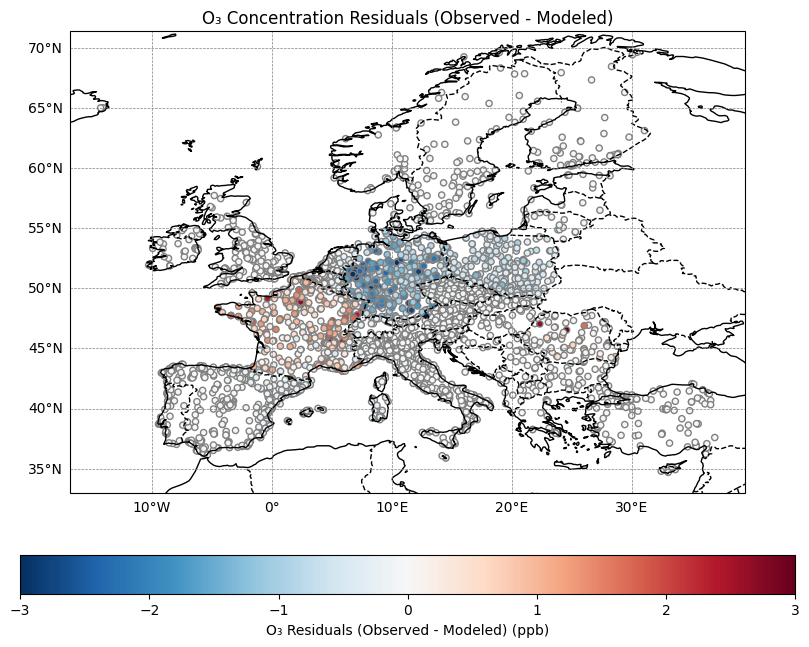

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseO3nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -3
cbar_max = 3

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["O3_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("O₃ Residuals (Observed - Modeled) (ppb)")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

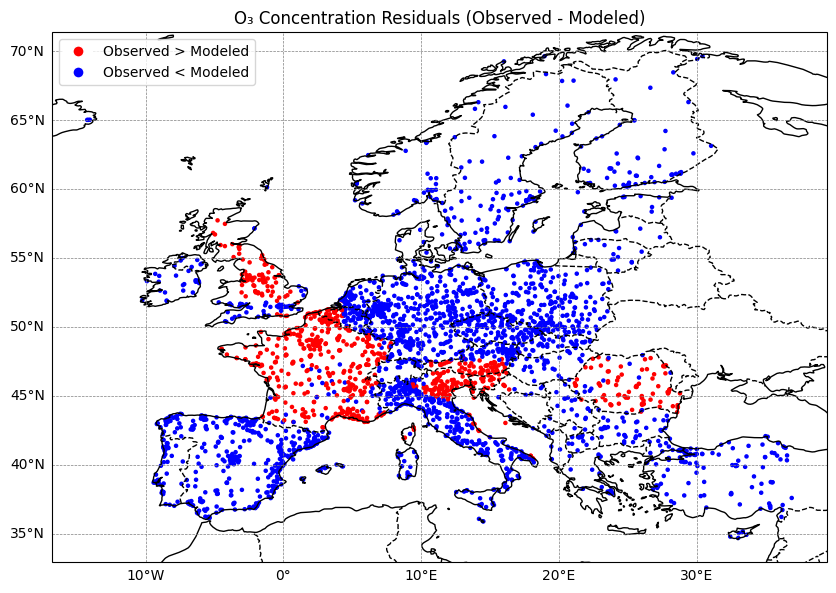

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.lines import Line2D

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseO3nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["O3_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (κόκκινο = Observed > Modeled, μπλε = Observed < Modeled)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

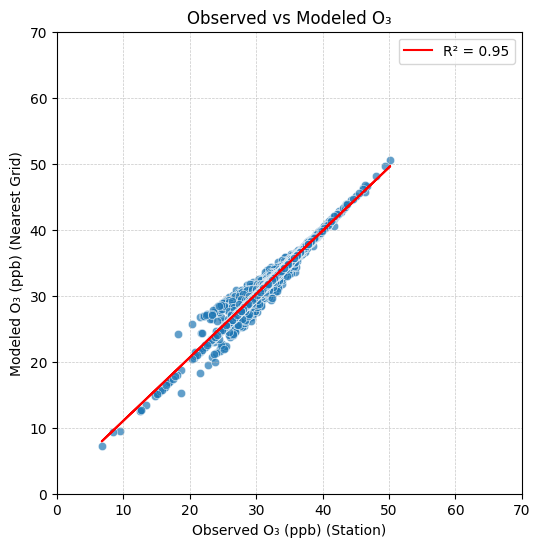

Mean Absolute Error (MAE): 0.47
Root Mean Squared Error (RMSE): 0.92


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("baseO3nearest_grid.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ppb_O3"]
modeled_O3 = stations["nearest_SURF_ppb_O3"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

#$NO_{2}$

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# --- Load Data ---
nc_file_path = "BaseCase_PERT_NO2_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_NO2.csv"

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values
no2_grid = nc_data["SURF_ug_NO2"].values.squeeze()

# Create grid points (lat, lon) and flatten NO2 values
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_deg = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))
grid_points_rad = np.radians(grid_points_deg)
no2_values = no2_grid.ravel()

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_no2 = station_data["SURF_ug_NO2"].values
station_coords_deg = np.column_stack((station_lats, station_lons))
station_coords_rad = np.radians(station_coords_deg)

# --- Nearest Grid Cell Matching (Haversine) ---
tree = BallTree(grid_points_rad, metric="haversine")
distances_rad, indices = tree.query(station_coords_rad, k=1)
nearest_indices = indices.flatten()
nearest_grid_coords = grid_points_deg[nearest_indices]  # (lat, lon)
nearest_no2_values = no2_values[nearest_indices]

# --- Create Output DataFrame ---
grid_cell_indices = list(zip(nearest_grid_coords[:, 1], nearest_grid_coords[:, 0]))  # (lon, lat)

df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_coords[:, 1],
    "nearest_grid_lat": nearest_grid_coords[:, 0],
    "grid_cell_index": grid_cell_indices,
    "SURF_ug_NO2": station_observed_no2,
    "nearest_SURF_ug_NO2": nearest_no2_values
})

df_matched = df_matched[[
    "lon", "lat", "nearest_grid_lon", "nearest_grid_lat",
    "grid_cell_index", "SURF_ug_NO2", "nearest_SURF_ug_NO2"
]]

# --- Save Final Results ---
df_matched.to_csv("baseNO2nearest_grid.csv", index=False)

print("✔ Done. File saved as 'baseNO2nearest_grid.csv'")


✔ Done. File saved as 'baseNO2nearest_grid.csv'


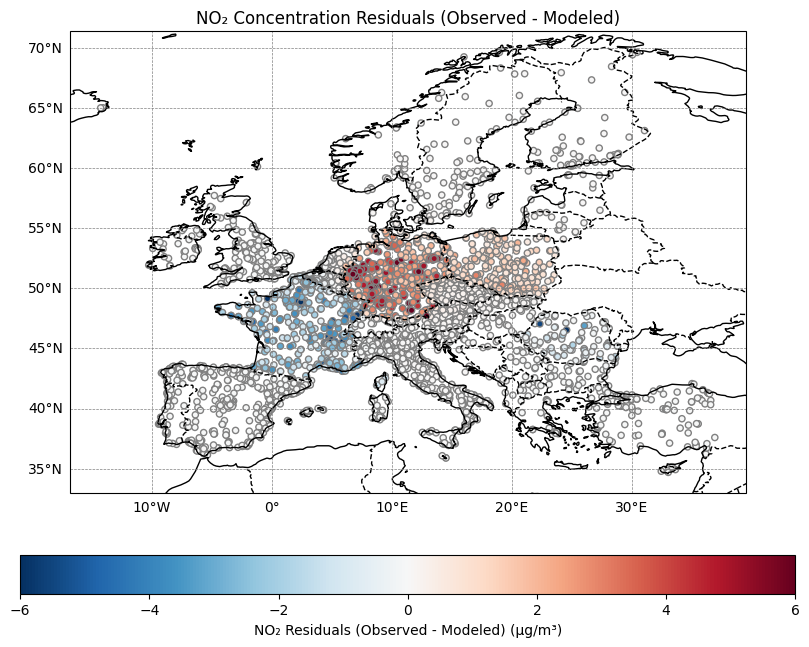

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseNO2nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["NO2_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("NO₂ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

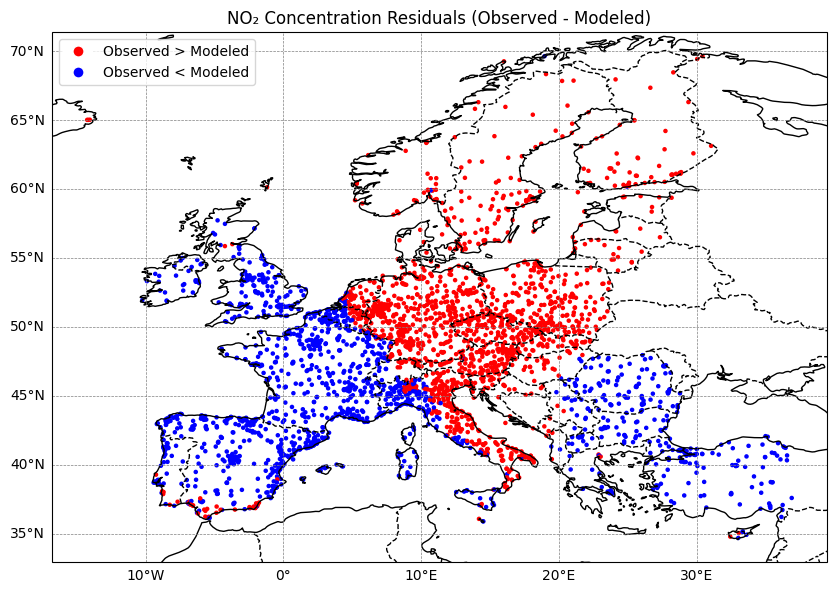

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.lines import Line2D

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseNO2nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["NO2_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με δύο χρώματα (κόκκινο = Observed > Modeled, μπλε = Observed < Modeled)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors= None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

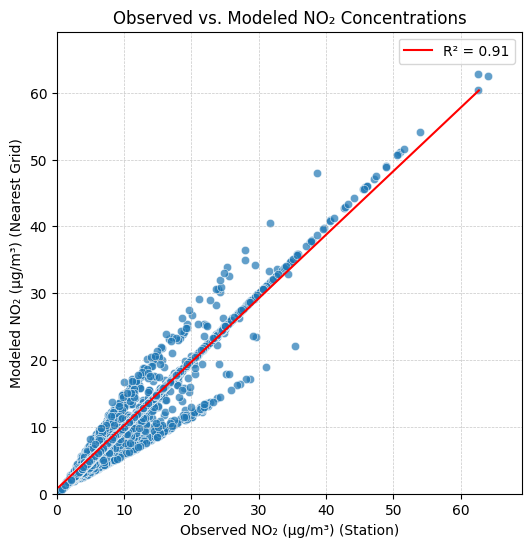

Mean Absolute Error (MAE): 1.09
Root Mean Squared Error (RMSE): 2.18


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
stations = pd.read_csv("baseNO2nearest_grid.csv")

# Extract observed and modeled NO₂ values
observed_NO2 = stations["SURF_ug_NO2"]
modeled_NO2 = stations["nearest_SURF_ug_NO2"]

# Perform linear regression (correct order: modeled → observed)
slope, intercept, r_value, p_value, std_err = linregress(modeled_NO2, observed_NO2)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_NO2, y=modeled_NO2, alpha=0.7)

# Generate regression line using modeled values (x-axis)
x_range = np.linspace(modeled_NO2.min(), modeled_NO2.max(), 100)
plt.plot(x_range, slope * x_range + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and dynamic grid limits
plt.xlabel("Observed NO₂ (µg/m³) (Station)")
plt.ylabel("Modeled NO₂ (µg/m³) (Nearest Grid)")
plt.title("Observed vs. Modeled NO₂ Concentrations")
plt.xlim(0, max(observed_NO2.max(), modeled_NO2.max()) + 5)
plt.ylim(0, max(observed_NO2.max(), modeled_NO2.max()) + 5)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_NO2, modeled_NO2)
rmse = np.sqrt(mean_squared_error(observed_NO2, modeled_NO2))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# $PM_{2.5}$

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# --- Load Data ---
nc_file_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_PM25_rh50.csv"

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values  # Grid center longitudes
lat_values = nc_data["lat"].values  # Grid center latitudes
pm25_grid = nc_data["SURF_ug_PM25_rh50"].values.squeeze()  # Remove time dimension

# Create grid points (lat, lon) and flatten PM2.5 values
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_deg = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # For BallTree: (lat, lon)
grid_points_rad = np.radians(grid_points_deg)
pm25_values = pm25_grid.ravel()

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_pm25 = station_data["SURF_ug_PM25_rh50"].values
station_coords_deg = np.column_stack((station_lats, station_lons))  # (lat, lon)
station_coords_rad = np.radians(station_coords_deg)

# --- Nearest Grid Cell Matching (Haversine) ---
tree = BallTree(grid_points_rad, metric="haversine")
distances_rad, indices = tree.query(station_coords_rad, k=1)
nearest_indices = indices.flatten()
nearest_grid_coords = grid_points_deg[nearest_indices]  # Still (lat, lon)
nearest_pm25_values = pm25_values[nearest_indices]

# --- Create Output DataFrame ---
grid_cell_indices = list(zip(nearest_grid_coords[:, 1], nearest_grid_coords[:, 0]))  # (lon, lat)

df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_coords[:, 1],
    "nearest_grid_lat": nearest_grid_coords[:, 0],
    "grid_cell_index": grid_cell_indices,
    "SURF_ug_PM25_rh50": station_observed_pm25,
    "nearest_SURF_ug_PM25_rh50": nearest_pm25_values
})

# Ensure correct column order
df_matched = df_matched[[
    "lon", "lat", "nearest_grid_lon", "nearest_grid_lat",
    "grid_cell_index", "SURF_ug_PM25_rh50", "nearest_SURF_ug_PM25_rh50"
]]

# --- Save Final CSV ---
df_matched.to_csv("basePM25nearest_grid.csv", index=False)

print(" Done. File saved as 'basePM25nearest_grid.csv'")

 Done. File saved as 'basePM25nearest_grid.csv'


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


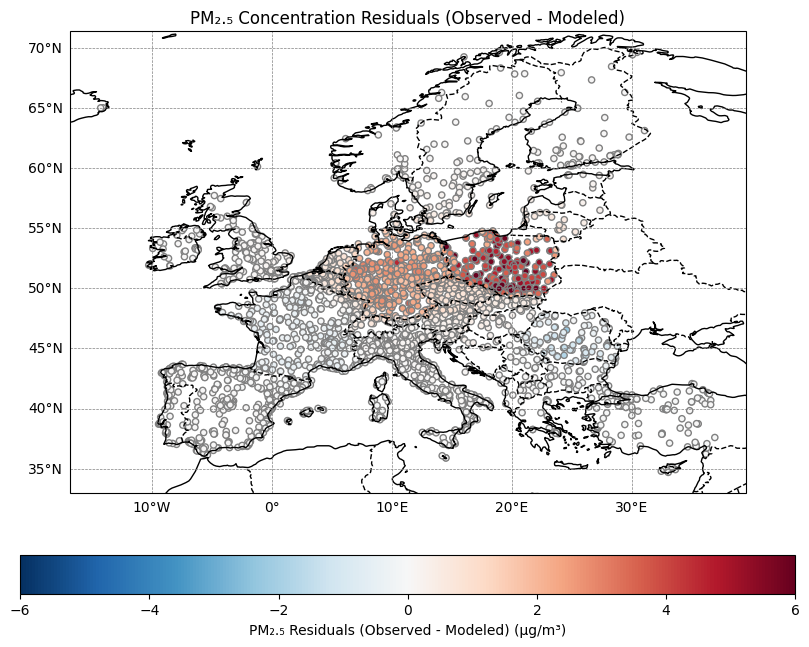

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("basePM25nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

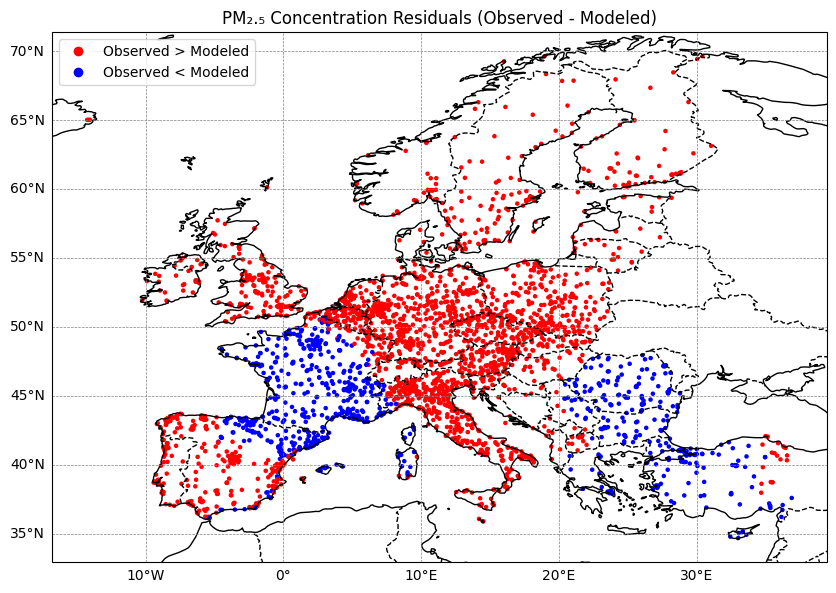

In [ ]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.lines import Line2D

# Φόρτωση των δεδομένων
stations = pd.read_csv("basePM25nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["PM25_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals PM₂.₅ με δύο χρώματα (κόκκινο = Observed > Modeled, μπλε = Observed < Modeled)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors= None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


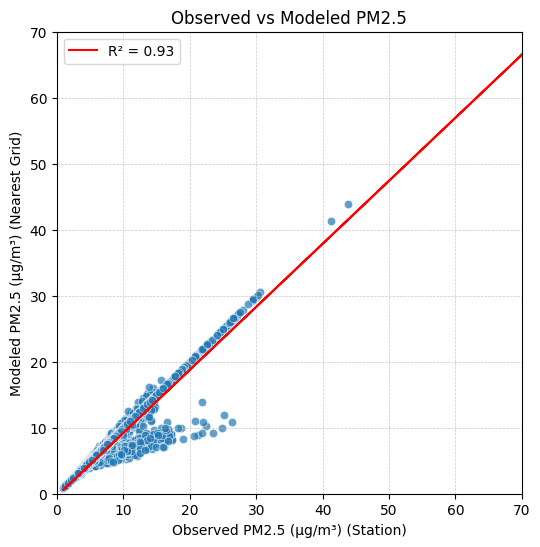

Mean Absolute Error (MAE): 0.88
Root Mean Squared Error (RMSE): 1.78


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("basePM25nearest_grid.csv")

# Extract observed and modeled PM2.5 values
observed_pm25 = stations["SURF_ug_PM25_rh50"]
modeled_pm25 = stations["nearest_SURF_ug_PM25_rh50"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_pm25, modeled_pm25)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_pm25, y=modeled_pm25, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_pm25, slope * observed_pm25 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed PM2.5 (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled PM2.5 (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled PM2.5")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_pm25, modeled_pm25)
rmse = np.sqrt(mean_squared_error(observed_pm25, modeled_pm25))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
